In [1]:
#Numpy:  librería de Python especializada en el cálculo numérico y el análisis de datos.
import numpy as np

#Matplotlib: librería de Python especializada en la creación de gráficos en dos dimensiones.
import matplotlib.pyplot as plt

#esta libreria permite caragar un
from joblib import load as ld

#para importar los archivos de audio
from scipy.io import wavfile as wav

from scipy.signal import filtfilt, hilbert

import sys

In [2]:
#concecta con google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pickle

# Load the model from Google Drive
model_path = '/content/drive/MyDrive/IA/Investigacion /EMG/Arbol de decision /decision_tree_model.pkl'
with open(model_path, 'rb') as f:
    model = pickle.load(f)

print("Model loaded successfully!")

Model loaded successfully!


In [70]:
ruta_archivo = '/content/drive/MyDrive/IA/Investigacion /EMG/Datos sin procesar/Bicep y tricep/archivos de audio/TRICEP/Atletismo/S1_ATL_TRI.wav'
try:
  print("importando registro " + ruta_archivo)
  [Fs, Signal] = wav.read(ruta_archivo)
except:
  print("Error al importar el registro")
  sys.exit()

importando registro /content/drive/MyDrive/IA/Investigacion /EMG/Datos sin procesar/Bicep y tricep/archivos de audio/TRICEP/Atletismo/S1_ATL_TRI.wav


In [6]:
pip install antropy

In [71]:
from antropy import hjorth_params

window_size_samples = 500
step_size_samples = 50  # 90% overlap

hjorth_features = []

for start_sample in range(0, len(Signal) - window_size_samples + 1, step_size_samples):
    end_sample = start_sample + window_size_samples
    segment = Signal[start_sample:end_sample]

    analytic_signal = hilbert(segment)
    analytic_real = np.real(analytic_signal)

    # Calcular Hjorth con antropy (solo devuelve movilidad y complejidad)
    mobility, complexity = hjorth_params(analytic_real)

    # Calcular actividad (varianza del segmento)
    activity = np.var(analytic_real)

    # Guardar características
    hjorth_features.append([activity, mobility, complexity])

hjorth_features = np.array(hjorth_features)

# Normalización min-max por columna
min_vals = np.min(hjorth_features, axis=0)
max_vals = np.max(hjorth_features, axis=0)
hjorth_features_norm = (hjorth_features - min_vals) / (max_vals - min_vals)

# Predicciones
predictions = []
for features in hjorth_features_norm:
    features = features.reshape(1, -1)
    prediction = model.predict(features)
    predictions.append(prediction[0])


Se truncaron las últimas líneas 5000 del resultado de transmisión.
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeC

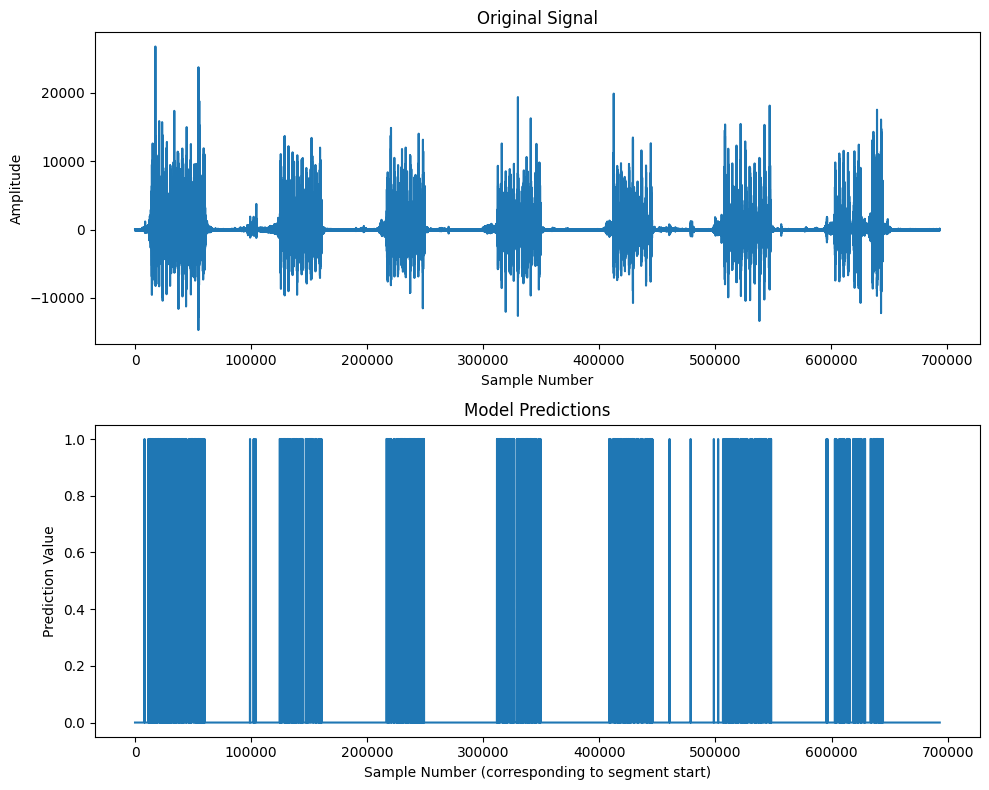

In [72]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with two subplots (2 rows, 1 column)
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot the original signal
axes[0].plot(Signal)
axes[0].set_title('Original Signal')
axes[0].set_xlabel('Sample Number')
axes[0].set_ylabel('Amplitude')

# Plot the predictions
# We need to create a time axis or index for the predictions
# Assuming each prediction corresponds to the start of a segment
prediction_indices = np.arange(len(predictions)) * step_size_samples

axes[1].plot(prediction_indices, predictions)
axes[1].set_title('Model Predictions')
axes[1].set_xlabel('Sample Number (corresponding to segment start)')
axes[1].set_ylabel('Prediction Value')

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plot
plt.show()

In [73]:
from scipy.ndimage import binary_closing, binary_dilation

def majority_vote_smooth(labels, window_size):
    """
    Sliding majority vote (voting window centered).
    labels: 1D numpy array de 0/1 (predicciones por segmento)
    window_size: número impar de vecinos (ej. 3,5,7). Si es par se suma 1.
    devuelve: labels suavizados por voto mayoritario
    """
    if window_size % 2 == 0:
        window_size += 1
    pad = window_size // 2
    padded = np.pad(labels, pad, mode='edge')
    smoothed = np.empty_like(labels)
    for i in range(len(labels)):
        window = padded[i:i+window_size]
        smoothed[i] = 1 if np.sum(window) > (window_size // 2) else 0
    return smoothed

def prob_smooth_and_threshold(probs, window_size, thr=0.5):
    """
    Suavizado de probabilidades con media móvil y umbral.
    probs: 1D numpy array de probabilidades [0..1]
    window_size: ventana para la media móvil (>=1)
    thr: umbral final para pasar a etiqueta binaria
    devuelve: etiquetas 0/1
    """
    kernel = np.ones(window_size) / window_size
    # convolución válida con padding reflect
    padded = np.pad(probs, (window_size//2,), mode='reflect')
    smoothed = np.convolve(padded, kernel, mode='valid')
    return (smoothed >= thr).astype(int)

def hysteresis_filter(labels, enter_count=2, exit_count=3):
    """
    Filtro por histéresis: se necesita `enter_count` positivos consecutivos
    para cambiar de 0->1 y `exit_count` negativos consecutivos para 1->0.
    Esto evita oscilaciones rápidas y reduce falsos negativos aislados.
    """
    out = np.zeros_like(labels)
    state = 0
    pos_run = 0
    neg_run = 0
    for i, v in enumerate(labels):
        if v == 1:
            pos_run += 1
            neg_run = 0
        else:
            neg_run += 1
            pos_run = 0

        if state == 0:
            if pos_run >= enter_count:
                state = 1
        else:
            if neg_run >= exit_count:
                state = 0

        out[i] = state
    return out

def morphological_postproc(labels, structure_size=3):
    """
    Usar operaciones morfológicas binarias para rellenar huecos cortos
    y eliminar falsos positivos breves.
    structure_size: tamaño del elemento estructurante (impar)
    """
    # convertir a booleano
    b = labels.astype(bool)
    # cerrar (dilatación seguida de erosión) para rellenar huecos
    closed = binary_closing(b, structure=np.ones(structure_size, dtype=bool))
    # opcional: dilatar para asegurar continuidad de segmentos verdaderos
    dilated = binary_dilation(closed, structure=np.ones(max(1, structure_size//2), dtype=bool))
    return dilated.astype(int)

In [74]:
predictions = np.array(predictions, dtype=int)

# 1) Voto mayoritario (suaviza oscilaciones rápidas)
smoothed_vote = majority_vote_smooth(predictions, window_size=5)

withprob = prob_smooth_and_threshold(smoothed_vote, window_size=50, thr=0.1)

# 2) Filtrado por histéresis para reducir falsos negativos aislados
hyst = hysteresis_filter(predictions, enter_count=2, exit_count=4)

# 3) Operaciones morfológicas para rellenar pequeños huecos y consolidar segmentos
final_labels = morphological_postproc(predictions, structure_size=5)

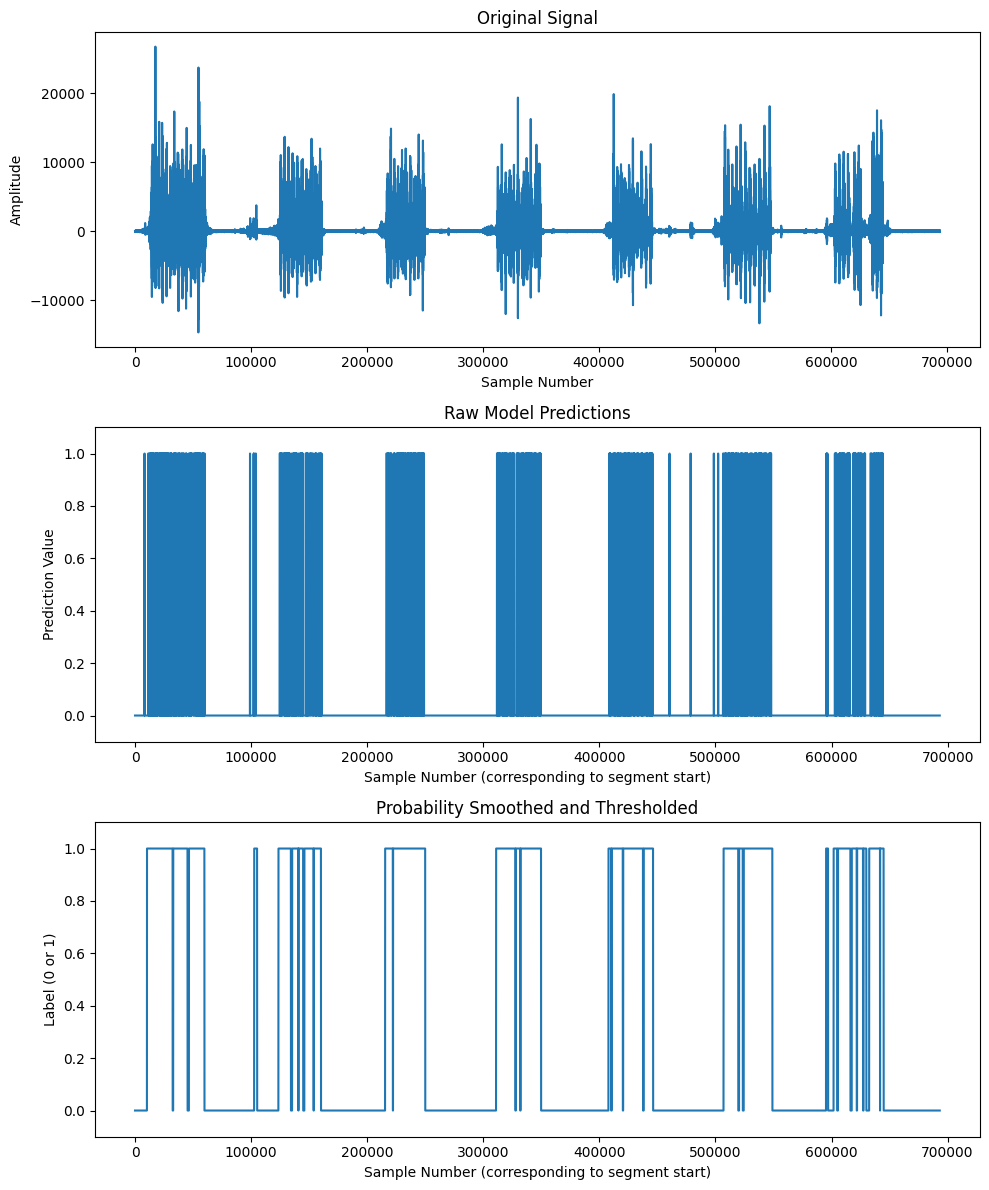

In [75]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with three subplots (3 rows, 1 column)
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=False) # sharex=False as signal and predictions/withprob might have different x-axes if not careful

# Plot the original signal
axes[0].plot(Signal)
axes[0].set_title('Original Signal')
axes[0].set_xlabel('Sample Number')
axes[0].set_ylabel('Amplitude')

# Create a time axis or index for the predictions
prediction_indices = np.arange(len(predictions)) * step_size_samples # Assuming each element corresponds to a segment start

# Plot the raw predictions
axes[1].plot(prediction_indices, predictions)
axes[1].set_title('Raw Model Predictions')
axes[1].set_xlabel('Sample Number (corresponding to segment start)')
axes[1].set_ylabel('Prediction Value')
axes[1].set_ylim([-0.1, 1.1]) # Set y-limits for clarity

# Create a time axis or index specifically for withprob
# Its length might be different due to convolution mode='valid'
withprob_indices = np.arange(len(withprob)) * step_size_samples # Assuming each element still corresponds to a segment start

# Plot withprob
axes[2].plot(withprob_indices, withprob)
axes[2].set_title('Probability Smoothed and Thresholded')
axes[2].set_xlabel('Sample Number (corresponding to segment start)')
axes[2].set_ylabel('Label (0 or 1)')
axes[2].set_ylim([-0.1, 1.1]) # Set y-limits for clarity


# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plot
plt.show()

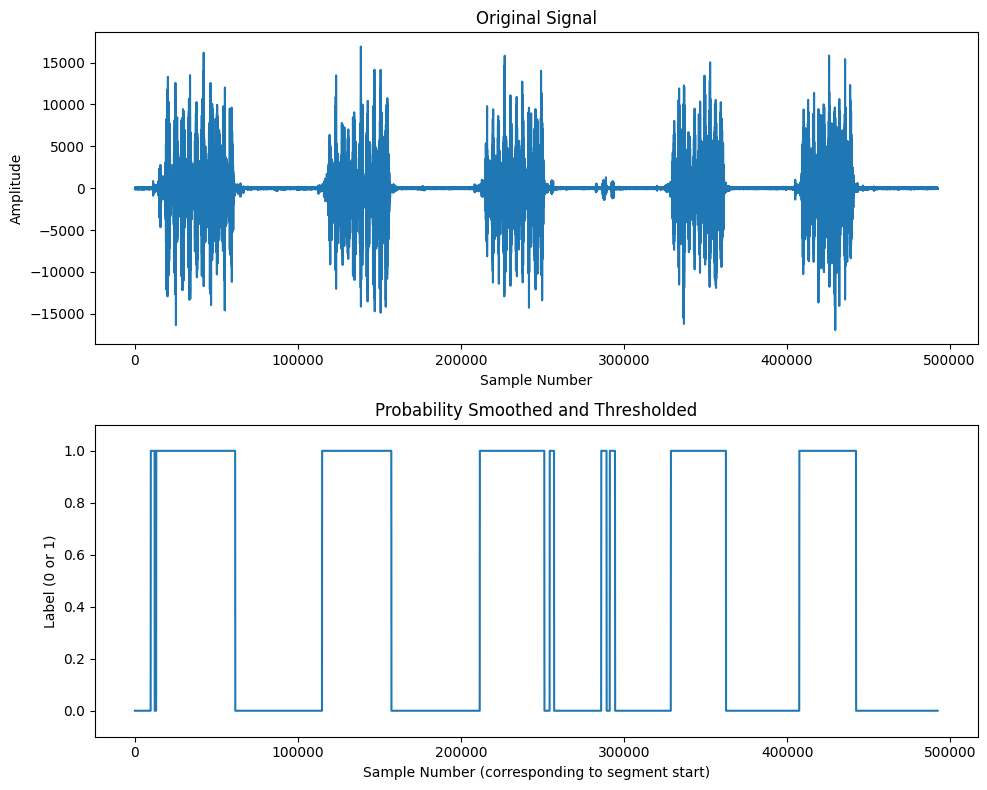

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with two subplots (2 rows, 1 column)
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=False) # sharex=False as signal and withprob might have different x-axes if not careful

# Plot the original signal
axes[0].plot(Signal)
axes[0].set_title('Original Signal')
axes[0].set_xlabel('Sample Number')
axes[0].set_ylabel('Amplitude')

# Create a time axis or index specifically for withprob
# Its length might be different due to convolution mode='valid'
withprob_indices = np.arange(len(withprob)) * step_size_samples # Assuming each element still corresponds to a segment start

# Plot withprob
axes[1].plot(withprob_indices, withprob)
axes[1].set_title('Probability Smoothed and Thresholded')
axes[1].set_xlabel('Sample Number (corresponding to segment start)')
axes[1].set_ylabel('Label (0 or 1)')
axes[1].set_ylim([-0.1, 1.1]) # Set y-limits for clarity


# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plot
plt.show()